LINEAR REGRESSION
- WaterMelon Market
<br>The paper on the watermelon market: "An Economic Model of the Watermelon Market (Suites, 1955)" 
<br> and the Suits' Watermelon model (Stewart, 2018) were referenced.
<br>
<br>The data of the above study were log-converted using commercial logs, and the data of the watermelon market here were log-converted using natural logs.


| Variable       | Description                                                              |
|:---------------|:-------------------------------------------------------------------------|
| Year           | Year (1930-1951)                                                         |
| log q (Q)      | Total number of watermelons available for harvest (millions)             |
| log h (X)      | Watermelons harvested (millions)                                         |
| log p (P)      | Average farm price of watermelons ($ per 1,000)                          |
| log p_c (C)    | Average annual net farm receipts per pound of ln_cotton_price (dollars)  |
| log p_v (T)    | Average farm price of vegetables (index)                                 |
| log w (W)      | Farm ln_wage_index rates in the South Atlantic States (index)            |
| log n (N)      | US population (milions)                                                  |
| log p_f (F)    | Railway ln_freight_cost_index costs for watermelons (index)              |
| log (y/n)(Y/N) | Per capita disposable (\$)                                               |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##  Data cleaning

###  Data preprocessing

Missing value processing method and pros and cons
1. A imputation method using trends : It is advantageous when the sample size is small
2. Dropping the missing values : Loss of sample count but simple
3. This sample has the missing values from the last year's wage index, so you can organize it as you proceed with the analysis

In [2]:
col_names = ['year', 'ln_crop', 'ln_harvest', 'ln_price', 'ln_cotton','ln_vegi',
             'ln_wage','ln_population','ln_income','ln_freight']
data = pd.read_excel('watermelon dataset.xlsx', names = col_names)
data.set_index("year", inplace= True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 1930 to 1951
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ln_crop        22 non-null     float64
 1   ln_harvest     22 non-null     float64
 2   ln_price       22 non-null     float64
 3   ln_cotton      22 non-null     float64
 4   ln_vegi        21 non-null     float64
 5   ln_wage        21 non-null     float64
 6   ln_population  22 non-null     float64
 7   ln_income      22 non-null     float64
 8   ln_freight     22 non-null     float64
dtypes: float64(9)
memory usage: 1.7 KB


###  Multicollinearity

- There is a significant correlation between variables that tend to increase during the sample period, including price-related variables.
- (In time series case) Even if there is no actual 'correlation' between data, there are many cases of spurious relationships.

####  pair-wise correlation
- There is a significant correlation between the remaining variables except for cultivation, yield, and vegetable price index.
- Since it is time series data, the correlation of variables related to the economy is highly likely not to lead to a causal relationship.
- Estimate a regression equation that includes all related variables, and if the confidence interval is too wide, remove highly correlated variables.

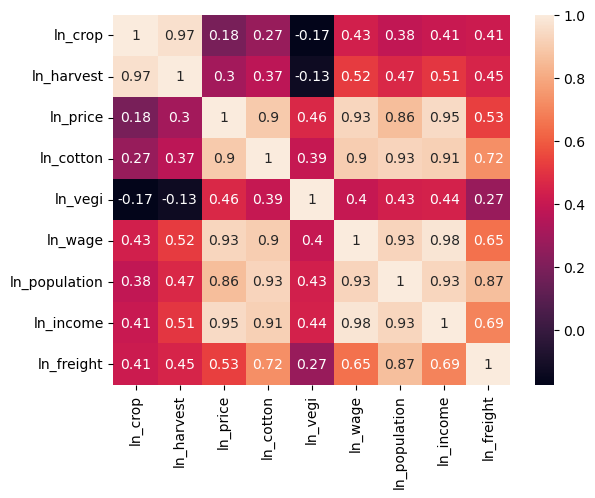

In [3]:
sns.heatmap(data.corr(), annot = True)
plt.show()

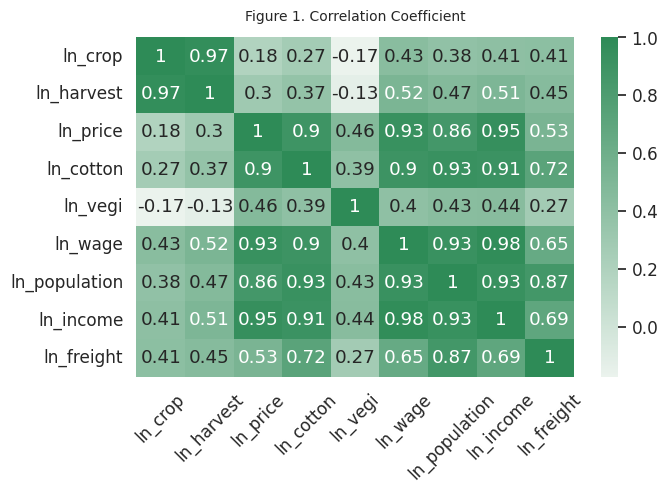

In [4]:
sns.set(font_scale = 1.1)
cmap = sns.light_palette("seagreen",as_cmap = True)
fig, ax = plt.subplots(figsize = (7,5))
corr = sns.heatmap(data.corr(), annot= True, cmap = cmap, ax= ax)
plt.xticks(rotation = 45)
corr.set_title("Figure 1. Correlation Coefficient", fontdict ={'fontsize':10},pad =12)
fig.tight_layout()

sns.reset_orig()
plt.show()

#### variation inflation factor
- Inputs are almost linear dependent.
- Estimating a regression equation containing all variables is highly likely to yield estimates that are impossible to calculate or statistically meaningless.
- When such a situation occurs, variables should be excluded one by one by referring to the theory and VIF values.

In [5]:
def vif(features):
    features = sm.add_constant(features)
    features.dropna(inplace = True)
    
    vif = pd.DataFrame([variance_inflation_factor(features.values, i) 
                        for i in range(features.shape[1])], columns = ["VIF"])
    vif.index = features.columns
    return vif

In [6]:
display(vif(data).T) #vif(data).round(2).to_markdown()

,const,ln_crop,ln_harvest,ln_price,ln_cotton,ln_vegi,ln_wage,ln_population,ln_income,ln_freight
VIF,170552.296097,29.179093,19.025893,80.712663,10.168122,1.656494,100.51583,38.27592,39.404538,12.677495


## Supply curve estimation
- Watermelon cultivation(q) as dependent variable
- Cultivation and harvest (harvest, log g) are different from decision-making times and constraints, so be careful.

### Stationarity
- Spurious relationship may occur if variables are non-stationary
- Pay attention to the general interpretation that there is some correlation between time series variables with unit root.

In [7]:
from statsmodels.tsa.stattools import adfuller
print(f"| Variable      | stat  | P-value |")
print(f"-----------------------------------")
for feature in data.columns[:]:
    test = adfuller(data.loc[:,feature].dropna())
    print(f"| {feature:<13} | {test[0]:+.2f} | {test[1]:.5f} |") #unit root in all
    # However, Suites explains that it is treated as stationary in consideration of various things. (Lower part of page 7 of the Paper)

| Variable      | stat  | P-value |
-----------------------------------
| ln_crop       | +1.49 | 0.99749 |
| ln_harvest    | +0.38 | 0.98087 |
| ln_price      | -9.58 | 0.00000 |
| ln_cotton     | -2.33 | 0.16324 |
| ln_vegi       | -1.09 | 0.71772 |
| ln_wage       | -0.75 | 0.83238 |
| ln_population | +7.82 | 1.00000 |
| ln_income     | -0.64 | 0.86280 |
| ln_freight    | -2.73 | 0.06896 |


### 회귀식 유도

#### 공급함수와 역공급함수
- 공급함수와 역공급함수 추정의 장단점 비교
1. 수평적 해석 : 주어진 가격에서 얼마나 생산을 할 것인지, 가격 = 한계비용(q)
2. 수직적 해석 : 각 생산향에서 판매할 용의가 있는 가격은 얼마인지
<br>
- 완전경쟁시장 조건이 만족하면 어떤 식을 주정해도 좋지만, 해당 조건을 만족하는 자료는 구하기 어렵다
- 단순 회귀 분석에서는 결정계수로 어떤 모형이 더 적합한지 판단할 수 없다
- 다중 회귀 분석에서는 R-sqaured에 차이가 나는 것이 일반적이다. 
- 둘 모두 이론석으로 문제가 없다면 사용할 수 있는 설명변수나 결정계수에 근거한 모형선택도 나쁘지 않다
<br><br>
- 파종량을 결정할 당시 참고할 수 있는 정보들은 당시의 값들이다
- 반면 최종 생산물의 가격은 몇 달 후에 결정된다
<br><br>
- 의사결정의 시간흐름을 생각해보면 역공급함수를 이용하는 것은 결과의 해석을 어렵게 한다


#### 변수 선택
- 재배량 결정에 영향을 미치는 변수들을 선택하고 그 근거를 설명한다
- 사용할 변수들의 VIF를 계산하고 이전 값과 비교하여 어떤 차이가 있는지 그 원인을 설명해 보자
<br><br>
- 공급 곡선은 가격이 재배량에 미치는 영향을 파악하기 위한 것으로 수박의 가격은 필수적으로 포함되어야 한다
- 한편 공급에 영향을 미치는 요인들을 모두 통제해야하므로 생산기술, 생산대체재, 공급측면의 정책을 변수로 포함시킨다.
<br><br>
- 면화가격, 야채가격, 임금, 그리고 이후 소개할 cotton acreage allotment program과 2차 세계대전을 고려한다. 모든 변수들은 다른 변수들과 상관관계를 살펴보고 포함여부를 결정한다

#### 시점 선택
- 재배량 결정은 재배시점에선 알 수 없는 수확 시점의 시장상황에 영향을 받는다. 합리적 기대와 적응적 기대를 비교설명하고 선택한 모형에 근거해 회귀식에서 독립변수를 어떻게 사용할지 설명해보자
<br><br>
- 수박 재배에는 시간이 걸리고 보관기간이 길지 않으므로 파종 결정에 실제 판매가격을 참고할 수 없다
- 따라서 과거 가격에 근거하여 생산결정을 내린다고 가정한다
- 마찬가지 이유로 다른 대체작물들의 가격 역시 실제 가격을 참고할 수 없다
<br><br>
- 합리적 기대가설에 근거해 같은 시점의 재배량과 가격을 사용할 수도 있다
- 권장하는 방법은 둘 모두 사용해보고 추정계수를 비교하는 것이다
<br><br>
- 임금은 재배량 결정과 같은 시점의 값을 고려하는 것이 타당해 보인다

### 회귀식 추정
- 유도한 회귀식을 OLS로 추정한다
- 내생성 문제가 발생할 가능성이 있다면 유도한 회귀식을 2SLS로 추정한다. 1단계 추정은 식별주건에 주의해서 가능한 모든 변수를 포함시켜 추정한다

In [8]:
q = data.ln_crop
wage = data.ln_wage
prices = data[['ln_price','ln_cotton','ln_vegi']].shift()
x = pd.concat((wage, prices),axis = 1)

In [9]:
X = sm.add_constant(x)
supply = sm.OLS(q,X, missing = "drop").fit()
print(supply.summary()) 
#Each variable is insignificant and the explanatory power of the regression equation is poor.

                            OLS Regression Results                            
Dep. Variable:                ln_crop   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     5.847
Date:                Mon, 06 Feb 2023   Prob (F-statistic):            0.00484
Time:                        19:04:52   Log-Likelihood:                 37.241
No. Observations:                  20   AIC:                            -64.48
Df Residuals:                      15   BIC:                            -59.50
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5926      0.112     14.216      0.0

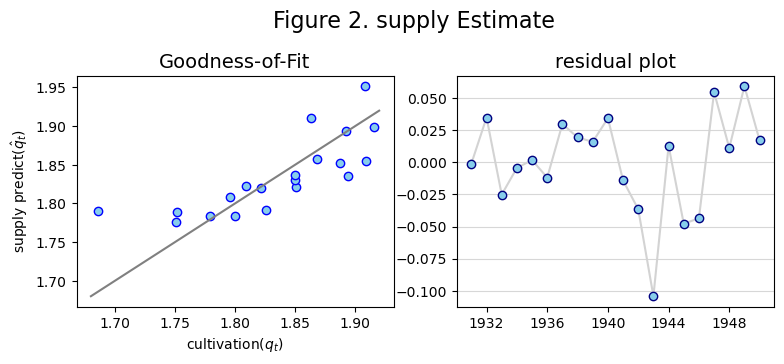

In [10]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9,3))

ax0.plot(q, supply.predict(X), "o", color = "blue", markerfacecolor = "skyblue")
ax0.plot(np.linspace(1.68, 1.92), np.linspace(1.68, 1.92), c= "gray")
ax0.set_xlabel(r"cultivation($q_t$)", fontsize = 10)
ax0.set_ylabel(r"supply predict($\hat{q}_t$)", fontsize = 10)
ax0.set_title("Goodness-of-Fit",fontsize = 14)


ax1.plot(q - supply.fittedvalues, "o-", color = "lightgray", 
         markerfacecolor = "skyblue", markeredgecolor = "navy")
ax1.set_xticks(range(1932,1952,4))
ax1.set_title("residual plot", fontsize = 14)
ax1.grid(axis = "y",alpha=0.5)

plt.suptitle("Figure 2. supply Estimate",fontsize = 16, y = 1.1)
plt.show()

### 표본기간 중 발생한 주목할만한 사건

#### 2차 세계대전
- 공식적인 2차세계 대전은 1939-09-01에 시작하여 1945-09-02에 종전이 되었다
- 하지만 미국은 진주만 공습 이후 1941-12-11에 공식적인 참전을 결정한다

#### 정부정책 
- 1934년 이후부터 표본기간 내내 cotton acreage allotment program이 실행되었다. 이 프로그램은 약속된 비율로 면화가격을 보상해주는 것으로 수박 재배 의사결정에 영향을 미칠 가능성이 높다
- 예상된 정책이므로 해당년도부터 바로 효과가 있었을 가능성이 높으므로 1934년부터 표본의 마지막 년도인 1951년까지 time dummy를 만들어 사용한다
- Dummy는 보통 사건이 발생한 다음 기부터 사건 종료 다음 기까지를 유효한 기간으로 취급한다. 미국의 수박생산농가가 1941년 의사결정에 2차 세계대전을 심각하게 고려했을 가능성은 크지 않아보이므로 1942년 혹은 1943년 부터 재배량에 영향을 받았을 가능성이 많다
- 1942-46혹은 1943-46을 2차 세계대전에 대한 time-dummy로 사용하고 결과를 비교한다

In [11]:
acreage_program = pd.DataFrame(((x.index >= 1934)&(x.index <= 1951)).astype(int), 
                               index = x.index, columns = ["cotton_program"])
ww2 = pd.DataFrame(((x.index >= 1943)&(x.index <= 1946)).astype(int), 
                               index = x.index, columns = ["ww2"])
X_ = pd.concat([X.drop('ln_wage', axis= 1), acreage_program, ww2], axis =1)

supply = sm.OLS(q,X_, missing = "drop").fit()
print(supply.summary())
#Each regression coefficient is significant and the explanatory power of the regression equation is high.

                            OLS Regression Results                            
Dep. Variable:                ln_crop   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.375e+04
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           6.74e-27
Time:                        19:04:52   Log-Likelihood:                 117.30
No. Observations:                  21   AIC:                            -222.6
Df Residuals:                      15   BIC:                            -216.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0528      0.004    273.

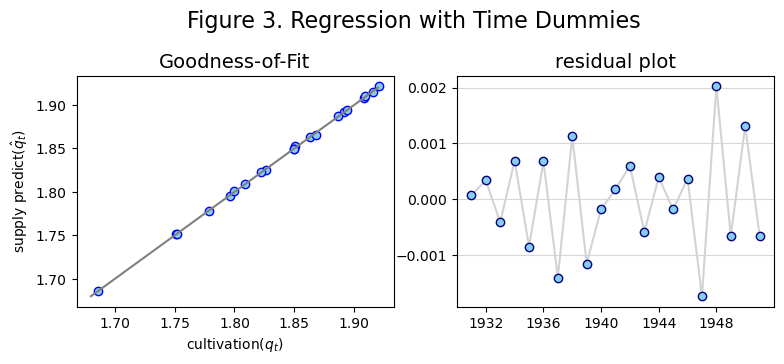

In [12]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9,3))

ax0.plot(q, supply.predict(X_), "o", color = "blue", markerfacecolor = "skyblue")
ax0.plot(np.linspace(1.68, 1.92), np.linspace(1.68, 1.92), c= "gray")
ax0.set_ylabel(r"supply predict($\hat{q}_t$)", fontsize = 10)
ax0.set_xlabel(r"cultivation($q_t$)", fontsize = 10)
ax0.set_title("Goodness-of-Fit",fontsize = 14)

ax1.plot(q - supply.predict(X_), "o-", color = "lightgray", 
         markerfacecolor = "skyblue", markeredgecolor = "navy")
ax1.set_xticks(range(1932,1952,4))
ax1.set_title("residual plot", fontsize = 14)
ax1.grid(axis = "y",alpha=0.5)

plt.suptitle("Figure 3. Regression with Time Dummies",fontsize = 16,y=1.1)
plt.show()